<a href="https://colab.research.google.com/github/feli1984/adaptacionUpliftRedesneuronales/blob/main/Tesis_Redes_Neuronales_Empresa_Chilena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## I.- Cargamos Librerias

In [ ]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift catboost pandas
!pip install tensorflow
!pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklift.models import ClassTransformation
from xgboost import XGBClassifier
from sklift.models import TwoModels
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklift.viz import plot_qini_curve , plot_uplift_by_percentile , plot_uplift_curve ,plot_treatment_balance_curve 
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import os
import random
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from keras.losses import mean_squared_error,binary_crossentropy
from tensorflow.keras.layers import Dense
from keras.layers.core import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
!pip install causalml
from causalml.inference.tf import DragonNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K

from sklift.metrics import (
     uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, perfect_uplift_curve
 )

from causalml.inference.nn import CEVAE
import torch
import warnings
import logging


# Cargamos las librerias para poder hacer el sobremuestreo de la data con SMOTE y limpiando con ENN
# from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 12.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.9/535.9 KB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# II.- Cargamos datos + separamos datos

## 2.- Cargamos datos

In [ ]:
 df = pd.read_csv("/content/dataframe.csv")
 

In [ ]:
##clase utilidades, y configuraciones iniciales 
class utils:
  def __init__(self , dataset):
    self.dataset = dataset
    self.balance( self.dataset )
    self.alpha=0.05
    self.optimizer="rmsprop"
    self.reg = 0.01
    self.batch_size = 96
    self.epochs = 30
    self.input_dim = 29
    self.shape0 = (29,)
    #self.shape0 = (29,1)
    self.shape1 = 1
    self.test_size =0.1
    self.ratio_balance='auto'
    self.set_transformed_outcome( self.dataset )
  ## es requerido q el total de observaciones de T sea igual en 1 y en 0
  def balance(self , dataset   ):
    self.dataset = dataset
    qty=0
    if( len(self.dataset[ self.dataset['group'] ==1 ]) > len(self.dataset[ self.dataset['group'] ==0 ]) ):
      delete_in_group = 1
      qty = len(self.dataset[ self.dataset['group'] ==1 ]) - len(self.dataset[ self.dataset['group'] ==0 ])
    elif( len(self.dataset[ self.dataset['group'] == 0 ]) > len(self.dataset[ self.dataset['group'] ==1 ]) ):
      delete_in_group = 0
      qty = len(self.dataset[ self.dataset['group'] ==0 ]) - len(self.dataset[ self.dataset['group'] ==1 ])
    else:
      delete_in_group = -1
    if( delete_in_group!=-1 ):
      set_to_join_1 = self.dataset[ self.dataset['group'] != delete_in_group  ]
      set_to_join_2 = self.dataset[ self.dataset['group'] == delete_in_group  ]
      set_to_join_2_0 = set_to_join_2[ set_to_join_2['buy_campaing'] == 0  ]
      set_to_join_2_1 = set_to_join_2[ set_to_join_2['buy_campaing'] == 1  ]

      set_to_delete = set_to_join_2_0.iloc[0:len(set_to_join_2_0)-qty,:]

      df = pd.DataFrame(data=set_to_delete)
      self.dataset = pd.concat([set_to_join_1, set_to_delete, set_to_join_2_1])
      return self.dataset
  
  def _replaceitem( self, x):
    if( x >= 0.5 ):
      return 1
    return 0

  def clean_list(  self,list  ):
    new_list = []
    for index_ in range(len(list)):
      j = list[index_]
      new_list.append( (j[0]) )
    return new_list
      

  #aplicamos la transformacion de clases
  def set_transformed_outcome( self , dataset_  ):
    self.dataset = dataset_
    self.dataset["z"] = 0;
    self.dataset.loc[ (self.dataset['buy_campaing'] == 1) & (self.dataset['group'] == 1) , 'z' ] = 2
    self.dataset.loc[ (self.dataset['buy_campaing'] == 1) & (self.dataset['group'] == 0) , 'z' ] = -2
    return self.dataset

  #esta red tiene un estructura similar a la que se implementara en la red siamesa, el unico proposito de esta es analizar los metodos de balanceo
  def build_rn( self, optimizer = '' , dropout_rate=0.0  , activation = "relu" , neurons= 15):
    if( optimizer ==""):
      optimizer = self.optimizer    
    classifier = Sequential()
    classifier.add(Dense( neurons , activation = activation, input_dim = utils.input_dim  , input_shape=utils.shape0 , name="layer1") )
    classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units = 10, activation = "relu", name="layer2"))
    classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name="layer3"))

    classifier.compile( optimizer= optimizer, loss="binary_crossentropy" , metrics=["accuracy"],
                        )
    
    return classifier


  ## calcular los pesos
  def get_weights( self, y_train ):
    weights_ = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    weights_ = { 0 : weights_[0] , 1:weights_[1]  }
    return weights_

  ##para generar los pares
  def make_pairs(self, X_test , z ):
    input1 = X_test.copy()
    input2 = X_test.copy()

    input1 = np.hstack(( input1, np.zeros(( input1.shape[0], 1), dtype= input1.dtype)))
    input2 = np.hstack(( input2, np.zeros(( input2.shape[0], 1), dtype= input2.dtype)))
    input2[:,-1] = 1 #input 0 con T = 1 
    input1[:,-1] = 0 #input 1 con T = 0 

    return [input1, input2], z

  
    



utils = utils( df )
dataset = utils.balance( df )
dataset = utils.set_transformed_outcome( dataset )
seed_value= 333
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
dataset.shape

(4664, 30)

In [ ]:
#nos aseguramos que no existan datos nulos
dataset.dtypes
display(dataset.isnull().values.any())

False

In [ ]:
dataset["buy_campaing"].mean()*100

3.2804459691252146

In [ ]:
len(dataset[ dataset['group'] ==1 ])# 1 = Mk o Tratamiento

2332

In [ ]:
len(dataset[ dataset['group'] ==0 ])# 0 = Control 

2332

## 3.- Separación de datos Objetivo, tratamiento

In [ ]:
dataset_aux = dataset.copy()
train_dataset= dataset_aux.sample( frac = 1-utils.test_size) # saca el 90% de datos aleatorios 
test_dataset = dataset_aux.drop( train_dataset.index )# deja aquellos que no fueron sampleados

In [ ]:
train_dataset.shape

(4198, 30)

In [ ]:
smot =  SMOTEENN(sampling_strategy=0.6) 

over_x = train_dataset # data set balanceado 
over_y = over_x['buy_campaing'] # columna de compras 

del( over_x['buy_campaing']  )
del( over_x['z']  )

over_x_res, over_y_res = smot.fit_resample(over_x, over_y)
X_train = pd.DataFrame(over_x_res, columns=over_x.columns)
final_data = pd.DataFrame(data=X_train)
final_data = final_data.assign( buy_campaing = over_y_res)
final_data

# Balanceo
dataset_final = utils.balance( final_data )
dataset_final = utils.set_transformed_outcome( dataset_final )
dataset_final

,group,gender,year_birth,total_orders,total_m,total_f,total_o,regency,abandoned_cars,recupered_cars,...,maipu,nunoa,penalolen,providencia,puente alto,puerto montt,punta arenas,rancagua,buy_campaing,z
0,0,1,2,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,4,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,1,0,0,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,1,0,12899,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,1,0,0,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4308,1,1,3,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,1,2
4309,1,0,3,1,0,31136,0,5,0,0,...,0,0,0,0,0,0,0,0,1,2
4310,1,1,3,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,1,2
4311,1,0,3,2,0,181140,0,12,3,0,...,0,0,0,0,0,0,0,0,1,2


In [ ]:
dataset_final.shape

(3812, 30)

# III.- Redes 

## 4.- CEVAE

In [ ]:
data_aux = dataset_final.copy()
#data_aux = data_aux.drop('z', axis =1)   
target  = data_aux['buy_campaing'].values
treatment  = data_aux['group'].values

In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   data_aux, target, treatment, test_size=0.5 , stratify = target #random_state=42
)

In [ ]:
x_train = np.asarray(X_tr).astype(np.float32)
t_train = np.asarray(treat_tr).astype(np.float32)
y_train =  np.asarray(y_tr).astype(np.float32)
x_val =  np.asarray(X_val).astype(np.float32)

In [ ]:
# cevae model settings
num_layers = 5
num_epochs = 30
batch_size = 10

outcome_dist = "normal"
latent_dim = 5
hidden_dim = 5
learning_rate = 0.001
learning_rate_decay = 0.001


cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

In [ ]:
# fit
losses = cevae.fit(X=torch.tensor(x_train, dtype=torch.float),
                   treatment=torch.tensor(t_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
INFO:pyro.contrib.cevae:Training with 191 minibatches per epoch
DEBUG:pyro.contrib.cevae:step     0 loss = 39.653
DEBUG:pyro.contrib.cevae:step   100 loss = 59.7978
DEBUG:pyro.contrib.cevae:step   200 loss = 58.6028
DEBUG:pyro.contrib.cevae:step   300 loss = 69.5604
DEBUG:pyro.contrib.cevae:step   400 loss = 49.1046
DEBUG:pyro.contrib.cevae:step   500 loss = 37.202
DEBUG:pyro.contrib.cevae:step   600 loss = 49.2003
DEBUG:pyro.contrib.cevae:step   

In [ ]:
ite_train = cevae.predict(x_train)
ite_val = cevae.predict(x_val)

INFO:pyro.contrib.cevae:Evaluating 191 minibatches
DEBUG:pyro.contrib.cevae:batch ate = 0.386202
DEBUG:pyro.contrib.cevae:batch ate = 0.389197
DEBUG:pyro.contrib.cevae:batch ate = 0.386288
DEBUG:pyro.contrib.cevae:batch ate = 0.376655
DEBUG:pyro.contrib.cevae:batch ate = 0.385669
DEBUG:pyro.contrib.cevae:batch ate = 0.37273
DEBUG:pyro.contrib.cevae:batch ate = 0.37918
DEBUG:pyro.contrib.cevae:batch ate = 0.389245
DEBUG:pyro.contrib.cevae:batch ate = 0.386215
DEBUG:pyro.contrib.cevae:batch ate = 0.382327
DEBUG:pyro.contrib.cevae:batch ate = 0.395272
DEBUG:pyro.contrib.cevae:batch ate = 0.385427
DEBUG:pyro.contrib.cevae:batch ate = 0.395396
DEBUG:pyro.contrib.cevae:batch ate = 0.383078
DEBUG:pyro.contrib.cevae:batch ate = 0.379077
DEBUG:pyro.contrib.cevae:batch ate = 0.383179
DEBUG:pyro.contrib.cevae:batch ate = 0.382904
DEBUG:pyro.contrib.cevae:batch ate = 0.382373
DEBUG:pyro.contrib.cevae:batch ate = 0.386671
DEBUG:pyro.contrib.cevae:batch ate = 0.385025
DEBUG:pyro.contrib.cevae:batch 

In [ ]:
sd = np.std(ite_val)
sd

0.015819205

uplift_at_k: 0.3697
qini_auc_score: 0.0043
cv_uplift_auc_score: 0.0083
0.38448507 0.38361946


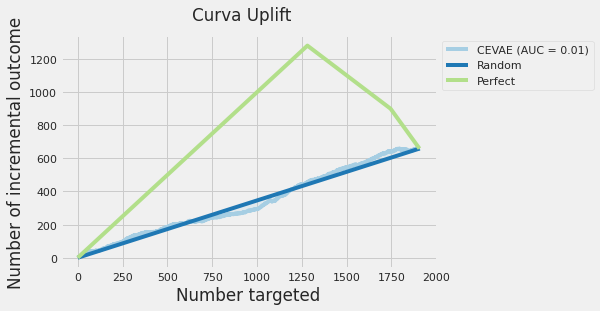

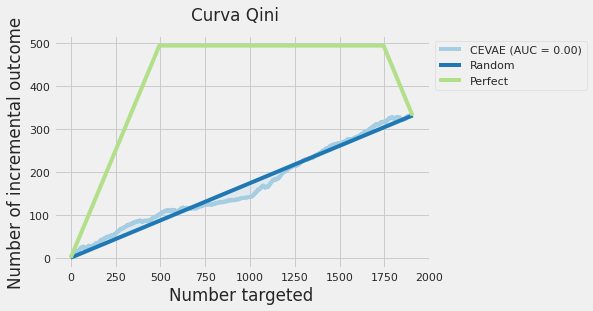

In [ ]:
CVAE_score = uplift_at_k(y_true=y_val, uplift=ite_val, treatment=treat_val, strategy='by_group', k=0.9)

cv_qini_auc_score = qini_auc_score(y_true=y_val, uplift=ite_val, treatment=treat_val)

cv_uplift_auc_score = uplift_auc_score(y_true=y_val, uplift=ite_val, treatment=treat_val)

uplift_cvae = plot_uplift_curve(y_val, ite_val, treat_val, perfect=True, name='CEVAE');
uplift_cvae.figure_.suptitle("Curva Uplift");



quini_cvae = plot_qini_curve(y_val, ite_val, treat_val, perfect=True, name='CEVAE');
quini_cvae.figure_.suptitle("Curva Qini");

print(f'uplift_at_k: {CVAE_score:.4f}')

print(f'qini_auc_score: {cv_qini_auc_score:.4f}')

print(f'cv_uplift_auc_score: {cv_uplift_auc_score:.4f}')

ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)






## 5.- SIAMESA CNN


In [ ]:
utils.batch_size = 10
utils.activation = 'relu'
utils.dropout_rate = 0.01
utils.nb_epoch = 30
utils.neurons = 20
utils.optimizer = 'adam'

In [ ]:
# classifier.add(Conv1D(filters=32, kernel_size=3, activation='relu' ,name="Conv1D_2"))
 # classifier.add(Conv1D(filters=16, kernel_size=2, activation='relu' ,name="Conv1D_3"))
 # classifier.add(Conv1D(filters=8, kernel_size=4, activation='relu' ,name="Conv1D_2"))
 
def build_siamese_model( optimizer = utils.optimizer ,dropout_rate = utils.dropout_rate, activation ="relu"):    
  classifier = Sequential()
  classifier.add(Conv1D(filters=64, kernel_size=6, activation='relu' ,name="Conv1D_1"))
  classifier.add(MaxPooling1D(pool_size=2))
  classifier.add(Conv1D(filters=32, kernel_size=4, activation='relu' ,name="Conv1D_2"))
  classifier.add(Conv1D(filters=16, kernel_size=2, activation='relu' ,name="Conv1D_3"))
  classifier.add(Flatten())
  classifier.add(Dropout(0.01))
  classifier.add(Dense(units = 50, activation = "relu", name="layer2"))
  classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name="layer3"))
  return classifier

In [ ]:
def subtraction(vectors):
  (u1, u0) = vectors
  subtracted = keras.layers.subtract([u1, u0])
  return subtracted 

#verdadero uplift
#µT = T µ1 + (1 − T)µ0
def u_t(vectors):
  (u1, u0, t) = vectors
  mul_u1_t = keras.layers.multiply([u1, t])
  mul_u0_t = keras.layers.multiply([u0, t])
  aux1 = keras.layers.add([mul_u1_t, u0])
  aux2 = keras.layers.subtract([aux1, mul_u0_t])  
  return aux2

## consultar al profe sobre esta funcion
def pi_y(vectors):
  (featsA, featsB, y) = vectors
  aux1 = keras.layers.add([featsA, featsB])
  aux2 = Lambda(lambda inputs: inputs[0] / (inputs[1]+tf.constant(1e-6)))([featsA, aux1])
  aux3=tf.constant(1.)-featsA
  aux4=tf.constant(1.)-featsB
  aux5= keras.layers.add([aux3, aux4])
  aux6 = Lambda(lambda inputs: inputs[0] / (inputs[1]+tf.constant(1e-6)))([aux3, aux5]) #para evitar division con 0
  aux7= keras.layers.multiply([y, aux2])
  aux8=tf.constant(1.)-y
  aux9= keras.layers.multiply([aux8, aux6])
  aux10 = keras.layers.add([aux7, aux9])  
  return aux10

def II_y( vectors ):
  (u1, u0, y) = vectors
  II_1 = Lambda(lambda x: x[0]/(x[1]+x[0]))([u1,u0])
  II_0 = Lambda(lambda x: (1-x[0])/((1-x[1])+(1-x[0])))([u1,u0])
  mul_u1_y = keras.layers.multiply([u1, y])
  mul_u0_y = keras.layers.multiply([u0, y])
  aux1 = keras.layers.add([mul_u1_y, u0])
  aux2 = keras.layers.subtract([aux1, mul_u0_y])
  return aux2



In [ ]:
data_aux = dataset_final.copy()
target  = data_aux['buy_campaing'].values
treatment  = data_aux['group'].values


In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   data_aux, target, treatment, test_size=0.5 , stratify = target #random_state=42
)
#y_test = y[i_test,]
y_test = target[treat_val,]
tt=data_aux['group'].values
t_train=tt[treat_tr,]
t_test=tt[treat_val,]
z = X_tr['z'].values

In [ ]:
##omitimos los binarios en el escalado
X = X_tr.iloc[:, 0:28] #no consideramos z ni y
colums_convert = X.columns[~X.isin([0,1]).all()]
features = X[ X.columns ]

ct = ColumnTransformer([
        ('data', StandardScaler(), colums_convert )
    ], remainder='passthrough')

#escalamos el dataset de entrenamiento
dataset_convert = ct.fit_transform(features)

#escalamos el dataset de prueba y exportamos la data en la data 
np.savetxt("data_pred.csv", test_dataset , delimiter=",")


X = test_dataset.iloc[:, 0:28] #no consideramos z ni y
features = X[ X.columns ]

h = X_tr.iloc[:, 0:28]
features2 = h[ h.columns ]

f = X_val.iloc[:, 0:28]
features3 = f[ f.columns ]

#X_prueba = dataset_convert.iloc[:, 0:28]

test_dataset_convert = ct.fit_transform(features)
train_dataset_convert = ct.fit_transform(features2)
val_dataset_convert = ct.fit_transform(features3)

In [ ]:
#estas as usaremos para las predicciones
y_to_pred = test_dataset['buy_campaing'].values
z_to_pred = test_dataset['z'].values
t_to_pred = test_dataset['group'].values
X_to_pred = test_dataset_convert

In [ ]:
y_to_train = X_tr['buy_campaing'].values
z_to_train = X_tr['z'].values
t_to_train = X_tr['group'].values
X_to_train = train_dataset_convert

In [ ]:
y_to_val = X_val['buy_campaing'].values
z_to_val = X_val['z'].values
t_to_val = X_val['group'].values
X_to_val = val_dataset_convert

In [ ]:
x_train = np.asarray(X_tr).astype(np.float32)
t_train = np.asarray(treat_tr).astype(np.float32)
y_train =  np.asarray(y_tr).astype(np.float32)
x_val =  np.asarray(X_val).astype(np.float32)


y_val = np.asarray(y_val).astype(np.float32)
y_to_pred = np.asarray(y_to_pred).astype(np.float32)
X_to_pred = np.asarray(X_to_pred).astype(np.float32)

y_to_train = np.asarray(y_to_train).astype(np.float32)
X_to_train = np.asarray(X_to_train).astype(np.float32)

y_to_val = np.asarray(y_to_val).astype(np.float32)
X_to_val = np.asarray(X_to_val).astype(np.float32)




In [ ]:
#Generación de pares
#entrenamiento
#pairTrain  , labelTrain=utils.make_pairs(x_train, y_train)
(pairTrain, labelTrain) = utils.make_pairs(X_to_train, z)
#validacion
#pairTest , labelTest  =  utils.make_pairs(x_val, y_val)
(pairTest_val, labelTest_val) = utils.make_pairs(X_to_val, y_to_val)
#prueba

(pairTest_to_pred, labelTest_to_pred) = utils.make_pairs(X_to_pred, y_to_pred)

(pairTest_to_train, labelTest_to_train) = utils.make_pairs(X_to_train, y_to_train)


In [ ]:
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
#configuracion de entradas

utils.shape0 = (29,1)

inputA = Input( utils.shape0 )
inputB = Input( utils.shape0 )

inputT = Input( utils.shape1)

label_z = Input(utils.shape1)

label_y = Input(utils.shape1)

label_t = Input(utils.shape1)


featureExtractor = build_siamese_model()
featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

In [ ]:
u1_u0 =  Lambda(subtraction)([featsA, featsB])
II_y =  Lambda(II_y)([featsA, featsB, label_y])
piy =  Lambda(pi_y)([featsA, featsB, label_y])
ut =  Lambda(u_t)([featsA, featsB, inputT])

loss = K.mean(((1-utils.alpha))*mean_squared_error(label_z,u1_u0) + (utils.alpha)*binary_crossentropy(label_y, ut ))

model_alter = Model(inputs=[inputA, inputB, inputT, label_t, label_y], outputs=[u1_u0,II_y,ut])



In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.0005)

model = Model(inputs=[inputA, inputB, inputT, label_z, label_y], outputs=[u1_u0,piy,ut])


model.add_loss(loss)
model.compile(opt)
# model.summary()

In [ ]:
#history1 = model.fit([pairTest_to_train,t_to_train,labelTest_to_train,y_to_train], 	batch_size= utils.batch_size, 
                        ##  epochs= utils.epochs ,callbacks=[model_checkpoint_callback_1] , verbose=0 )

In [ ]:
loss_alter = K.mean(((1-utils.alpha))*binary_crossentropy(label_t,II_y) + (utils.alpha)*binary_crossentropy(label_y, ut ))
model_alter.add_loss(loss_alter)



In [ ]:
model_alter.compile( opt )

In [ ]:
history2 = model_alter.fit([pairTest_to_train,t_to_train,labelTest_to_train,y_to_train], 	batch_size= utils.batch_size, 
                          epochs=15  ,callbacks=[model_checkpoint_callback_2] , verbose=False )

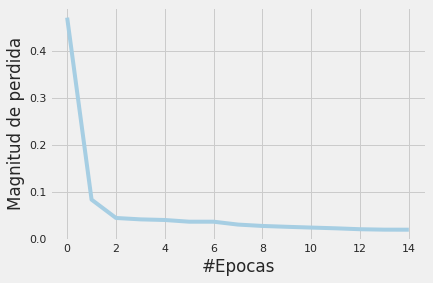

In [ ]:
plt.xlabel("#Epocas")
plt.ylabel("Magnitud de perdida")
plt.plot(history2.history["loss"])

60/60 [==============================] - 1s 5ms/step
ate_siamesa: 0.3498
uplift@90%: 0.3690
qini_auc_score: 0.1010
uplift_auc_score: 0.1011


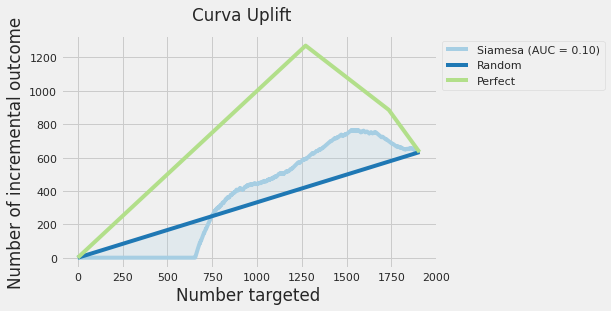

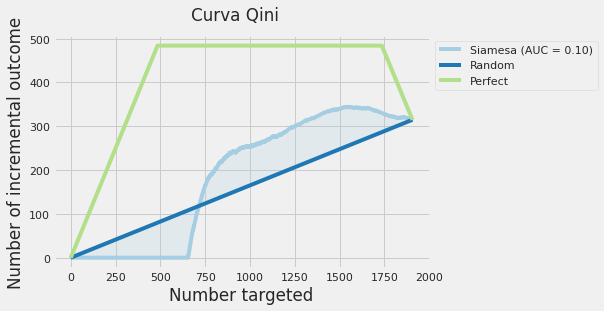

In [ ]:
ul = model_alter.predict([pairTest_val,t_to_val,labelTest_val,y_to_val])
#ul_alt = model_alter.predict([pairTest_val,t_to_val,labelTest_val,y_to_val])
ul_aux = ul[1].copy()
ul_ = utils.clean_list( ul_aux )

ul_ate_siamesa = sum(ul_)/len(ul_)

print(f'ate_siamesa: {ul_ate_siamesa:.4f}')

siamesa_score = uplift_at_k(y_true=y_to_val, uplift=ul_, treatment=t_to_val, strategy='by_group', k=0.9)
print(f'uplift@90%: {siamesa_score:.4f}')

sis_qini_auc_score = qini_auc_score(y_true=y_to_val, uplift=ul_, treatment=t_to_val)
print(f'qini_auc_score: {sis_qini_auc_score:.4f}')

sis_uplift_auc_score = uplift_auc_score(y_true=y_to_val, uplift=ul_, treatment=t_to_val)
print(f'uplift_auc_score: {sis_uplift_auc_score:.4f}')


uplift_sis = plot_uplift_curve(y_to_val, ul_, t_to_val, perfect=True, name='Siamesa');
uplift_sis.figure_.suptitle("Curva Uplift");

quini_sis = plot_qini_curve(y_to_val, ul_, t_to_val, perfect=True, name='Siamesa');
quini_sis.figure_.suptitle("Curva Qini");

## 6.- DRAGONNET


In [ ]:
data_aux = dataset_final.copy()
#data_aux = data_aux.drop('z', axis =1)   
target  = data_aux['buy_campaing'].values
treatment  = data_aux['group'].values


In [ ]:
from sklearn import preprocessing
data_aux.columns

Index(['group', 'gender', 'year_birth', 'total_orders', 'total_m', 'total_f',
       'total_o', 'regency', 'abandoned_cars', 'recupered_cars', 'orders_3',
       'orders_6', 'orders_9', 'campaing_subscribe', 'conversion',
       'spent_category', 'Others', 'colina', 'la reina', 'macul', 'maipu',
       'nunoa', 'penalolen', 'providencia', 'puente alto', 'puerto montt',
       'punta arenas', 'rancagua', 'buy_campaing', 'z'],
      dtype='object')

In [ ]:
le = preprocessing.LabelEncoder()

# Asignamos la codificación al dataset 
data_aux = data_aux.apply(le.fit_transform)


In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   data_aux, target, treatment, test_size=0.5, stratify = target ##stratify = target #
)

In [ ]:
dragon = DragonNet(neurons_per_layer=5, epochs=30 , batch_size=10)
dragon_ite = dragon.fit_predict(X_tr,treat_tr, np.asarray(y_tr).astype(np.float32),return_components=False)


In [ ]:
dragon_ite[ dragon_ite<=-1.0 ]=-1
dragon_ite[ dragon_ite>=1.0 ]=1


In [ ]:
dragon_ite = dragon_ite[:,0]

In [ ]:
dn_score = uplift_at_k(y_true=y_val, uplift=dragon_ite, treatment=treat_val, strategy='by_group', k=0.9)

ATE dragon: 0.4137
uplift@90%: 0.3439
qini_auc_score: 0.0036
dn_uplift_auc_score: 0.0034


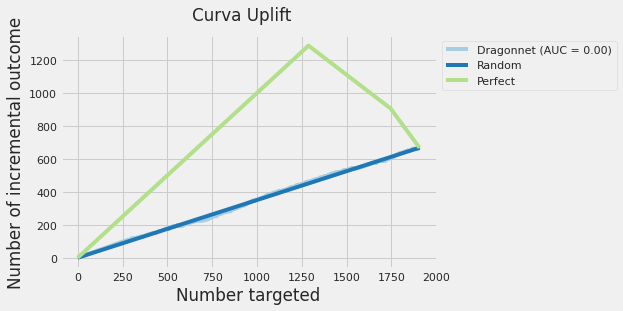

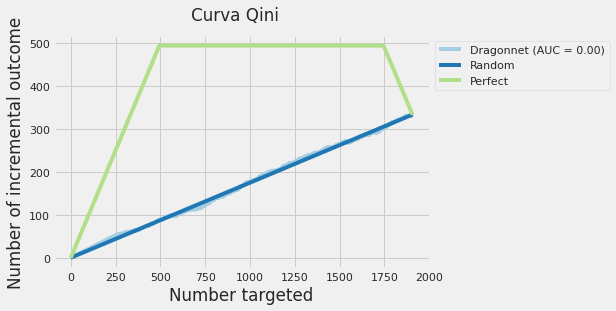

In [ ]:
dn_qini_auc_score = qini_auc_score(y_true=y_val, uplift=dragon_ite, treatment=treat_val)

dn_uplift_auc_score = uplift_auc_score(y_true=y_val, uplift=dragon_ite, treatment=treat_val)

uplift_dragon = plot_uplift_curve(y_val, dragon_ite, treat_val, perfect=True, name='Dragonnet');
uplift_dragon.figure_.suptitle("Curva Uplift");

uplift_disptwo = plot_qini_curve(y_val, dragon_ite, treat_val, perfect=True, name='Dragonnet');
uplift_disptwo.figure_.suptitle("Curva Qini");

dragon_ate = dragon_ite.mean()## promedio despues de truncart los datos 

print(f'ATE dragon: {dragon_ate:.4f}')
print(f'uplift@90%: {dn_score:.4f}')
print(f'qini_auc_score: {dn_qini_auc_score:.4f}')
print(f'dn_uplift_auc_score: {dn_uplift_auc_score:.4f}')




7.- convolucion 1D




## 8.- Siamesa sin cnn

In [ ]:
utils.batch_size = 10
utils.activation = 'relu'
utils.dropout_rate = 0.01
utils.nb_epoch = 30
utils.neurons = 20
utils.optimizer = 'adam'

In [ ]:
def build_siamese_model_sin_cnn( optimizer = utils.optimizer , dropout_rate = utils.dropout_rate, activation ="relu" , neurons= 20):    
  classifier = Sequential()
  classifier.add(Dense( neurons , activation = activation, input_dim = utils.input_dim  , input_shape=utils.shape0 , name="layer1") )
  classifier.add(Dropout(dropout_rate))
  classifier.add(Dense(units = 10, activation = "relu", name="layer2"))
  classifier.add(Dropout(dropout_rate))
  classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name="layer3"))
  return classifier

In [ ]:
def subtraction(vectors):
  (u1, u0) = vectors
  subtracted = keras.layers.subtract([u1, u0])
  return subtracted 

#verdadero uplift
#µT = T µ1 + (1 − T)µ0
def u_t(vectors):
  (u1, u0, t) = vectors
  mul_u1_t = keras.layers.multiply([u1, t])
  mul_u0_t = keras.layers.multiply([u0, t])
  aux1 = keras.layers.add([mul_u1_t, u0])
  aux2 = keras.layers.subtract([aux1, mul_u0_t])  
  return aux2

## consultar al profe sobre esta funcion
def pi_y(vectors):
  (featsA, featsB, y) = vectors
  aux1 = keras.layers.add([featsA, featsB])
  aux2 = Lambda(lambda inputs: inputs[0] / (inputs[1]+tf.constant(1e-6)))([featsA, aux1])
  aux3=tf.constant(1.)-featsA
  aux4=tf.constant(1.)-featsB
  aux5= keras.layers.add([aux3, aux4])
  aux6 = Lambda(lambda inputs: inputs[0] / (inputs[1]+tf.constant(1e-6)))([aux3, aux5]) #para evitar division con 0
  aux7= keras.layers.multiply([y, aux2])
  aux8=tf.constant(1.)-y
  aux9= keras.layers.multiply([aux8, aux6])
  aux10 = keras.layers.add([aux7, aux9])  
  return aux10

def II_y( vectors ):
  (u1, u0, y) = vectors
  II_1 = Lambda(lambda x: x[0]/(x[1]+x[0]))([u1,u0])
  II_0 = Lambda(lambda x: (1-x[0])/((1-x[1])+(1-x[0])))([u1,u0])
  mul_u1_y = keras.layers.multiply([u1, y])
  mul_u0_y = keras.layers.multiply([u0, y])
  aux1 = keras.layers.add([mul_u1_y, u0])
  aux2 = keras.layers.subtract([aux1, mul_u0_y])
  return aux2

In [ ]:
data_aux = dataset_final.copy()
target  = data_aux['buy_campaing'].values
treatment  = data_aux['group'].values


In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   data_aux, target, treatment, test_size=0.5 , stratify = target #random_state=42
)
#y_test = y[i_test,]
y_test = target[treat_val,]
tt=data_aux['group'].values
t_train=tt[treat_tr,]
t_test=tt[treat_val,]
z = X_tr['z'].values

In [ ]:
##omitimos los binarios en el escalado
X = X_tr.iloc[:, 0:28] #no consideramos z ni y
colums_convert = X.columns[~X.isin([0,1]).all()]
features = X[ X.columns ]

ct = ColumnTransformer([
        ('data', StandardScaler(), colums_convert )
    ], remainder='passthrough')

#escalamos el dataset de entrenamiento
dataset_convert = ct.fit_transform(features)

#escalamos el dataset de prueba y exportamos la data en la data 
np.savetxt("data_pred.csv", test_dataset , delimiter=",")


X = test_dataset.iloc[:, 0:28] #no consideramos z ni y
features = X[ X.columns ]

h = X_tr.iloc[:, 0:28]
features2 = h[ h.columns ]

f = X_val.iloc[:, 0:28]
features3 = f[ f.columns ]

#X_prueba = dataset_convert.iloc[:, 0:28]

test_dataset_convert = ct.fit_transform(features)
train_dataset_convert = ct.fit_transform(features2)
val_dataset_convert = ct.fit_transform(features3)

In [ ]:
#estas as usaremos para las predicciones
y_to_pred = test_dataset['buy_campaing'].values
z_to_pred = test_dataset['z'].values
t_to_pred = test_dataset['group'].values
X_to_pred = test_dataset_convert

In [ ]:
y_to_train = X_tr['buy_campaing'].values
z_to_train = X_tr['z'].values
t_to_train = X_tr['group'].values
X_to_train = train_dataset_convert

In [ ]:
y_to_val = X_val['buy_campaing'].values
z_to_val = X_val['z'].values
t_to_val = X_val['group'].values
X_to_val = val_dataset_convert

In [ ]:
x_train = np.asarray(X_tr).astype(np.float32)
t_train = np.asarray(treat_tr).astype(np.float32)
y_train =  np.asarray(y_tr).astype(np.float32)
x_val =  np.asarray(X_val).astype(np.float32)


y_val = np.asarray(y_val).astype(np.float32)
y_to_pred = np.asarray(y_to_pred).astype(np.float32)
X_to_pred = np.asarray(X_to_pred).astype(np.float32)

y_to_train = np.asarray(y_to_train).astype(np.float32)
X_to_train = np.asarray(X_to_train).astype(np.float32)

y_to_val = np.asarray(y_to_val).astype(np.float32)
X_to_val = np.asarray(X_to_val).astype(np.float32)

In [ ]:
#Generación de pares
#entrenamiento
#pairTrain  , labelTrain=utils.make_pairs(x_train, y_train)
(pairTrain, labelTrain) = utils.make_pairs(X_to_train, z)
#validacion
#pairTest , labelTest  =  utils.make_pairs(x_val, y_val)
(pairTest_val, labelTest_val) = utils.make_pairs(X_to_val, y_to_val)
#prueba

(pairTest_to_pred, labelTest_to_pred) = utils.make_pairs(X_to_pred, y_to_pred)

(pairTest_to_train, labelTest_to_train) = utils.make_pairs(X_to_train, y_to_train)

In [ ]:
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
#Configuracion de entradas de la red
utils.shape0 = (29,)
inputA = Input( utils.shape0 )
inputB = Input( utils.shape0 )

inputT = Input( utils.shape1)

label_z = Input(utils.shape1)

label_y = Input(utils.shape1)

label_t = Input(utils.shape1)


featureExtractor = build_siamese_model_sin_cnn() ## siamesa sin cnn
featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

In [ ]:
u1_u0 =  Lambda(subtraction)([featsA, featsB])
II_y =  Lambda(II_y)([featsA, featsB, label_y])
piy =  Lambda(pi_y)([featsA, featsB, label_y])
ut =  Lambda(u_t)([featsA, featsB, inputT])

loss = K.mean(((1-utils.alpha))*mean_squared_error(label_z,u1_u0) + (utils.alpha)*binary_crossentropy(label_y, ut ))

model_alter = Model(inputs=[inputA, inputB, inputT, label_t, label_y], outputs=[u1_u0,II_y,ut])

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.0005)

model = Model(inputs=[inputA, inputB, inputT, label_z, label_y], outputs=[u1_u0,piy,ut])
model = Model(inputs=[inputA, inputB, inputT, label_z, label_y], outputs=[u1_u0,piy,ut])

model.add_loss(loss)
model.compile(opt)
# model.summary()

In [ ]:
loss_alter = K.mean(((1-utils.alpha))*binary_crossentropy(label_t,II_y) + (utils.alpha)*binary_crossentropy(label_y, ut ))
model_alter.add_loss(loss_alter)

In [ ]:
model_alter.compile( opt )

In [ ]:
history2 = model_alter.fit([pairTest_to_train,t_to_train,labelTest_to_train,y_to_train], 	batch_size= utils.batch_size, 
                          epochs= 30 ,callbacks=[model_checkpoint_callback_2] , verbose=0 )

60/60 [==============================] - 1s 9ms/step
ate_siamesa: 0.3362
uplift@90%: 0.3841
qini_auc_score: 0.1377
uplift_auc_score: 0.1762


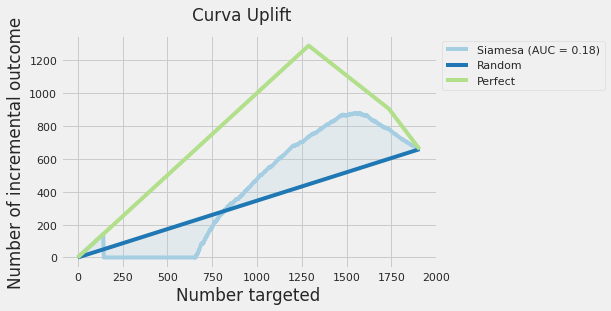

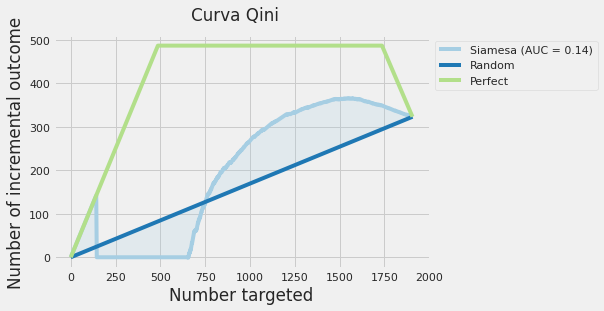

In [ ]:
ul = model_alter.predict([pairTest_val,t_to_val,labelTest_val,y_to_val])
#ul_alt = model_alter.predict([pairTest_val,t_to_val,labelTest_val,y_to_val])
ul_aux = ul[1].copy()
ul_ = utils.clean_list( ul_aux )


ul_ate_siamesa = sum(ul_)/len(ul_)

print(f'ate_siamesa: {ul_ate_siamesa:.4f}')

siamesa_score = uplift_at_k(y_true=y_to_val, uplift=ul_, treatment=t_to_val, strategy='by_group', k=0.9)
print(f'uplift@90%: {siamesa_score:.4f}')

sis_qini_auc_score = qini_auc_score(y_true=y_to_val, uplift=ul_, treatment=t_to_val)
print(f'qini_auc_score: {sis_qini_auc_score:.4f}')

sis_uplift_auc_score = uplift_auc_score(y_true=y_to_val, uplift=ul_, treatment=t_to_val)
print(f'uplift_auc_score: {sis_uplift_auc_score:.4f}')


uplift_sis = plot_uplift_curve(y_to_val, ul_, t_to_val, perfect=True, name='Siamesa');
uplift_sis.figure_.suptitle("Curva Uplift");

quini_sis = plot_qini_curve(y_to_val, ul_, t_to_val, perfect=True, name='Siamesa');
quini_sis.figure_.suptitle("Curva Qini");